# Text Analytics - Assignment 4 
# NLP (Text Classification) With Recurrent Neural Nets

---

> Kostis Konstantinos (p3352311) <br>
> MSc Data-Science (Part-Time) <br>
> Athens University Of Economics and Business

In [ ]:
# Install libraries (via pip) for Google Colab

# !pip install -U conllu gensim pandas requests tensorflow==2.15.0 keras-tuner scikit-learn matplotlib ipdb

In [1]:
# Load libraries
import os

# INFO, WARNING and ERROR messages are not printed
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  

from io import open
from collections import Counter

from conllu import parse_incr
import requests

import gensim.downloader as api

import numpy as np
import pandas as pd

import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Input, Embedding,
                                     Bidirectional, GRU, TimeDistributed)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import (f1_score, recall_score, precision_score, 
                             auc, precision_recall_curve)
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
%matplotlib inline

### Setting a random seed (for reproducibility)

In [2]:
seed = 2024
np.random.seed(seed)
tf.random.set_seed(seed)

### Dataset (Description & Helper Classes)

The dataset used, refers to the english language of the Universal Dependencies tree banks and more specifically GUM from Georgetown University.
It contains 10761 sentences from different genres: academic, blog, fiction, government, news, nonfiction, social, spoken, web, wiki.
The dataset is downloaded from Github and parsed using the conllu package, via a custom class named DatasetHandler.

Treebank index page can be found here https://universaldependencies.org/treebanks/en_gum/index.html \
The actual data (train, dev, test) files can be found at https://github.com/UniversalDependencies/UD_English-GUM/tree/master

In [3]:
# Download and parse train, dev and test splits (download from github)

class DatasetHandler:
    """ DatasetHandler
    
    Downloads and parses the universal-dependencies/en-gmu data files.
    """
    def __init__(self, url, mode):
        self.url = url
        self.mode = mode

        self.sentences = []
        
        self.data_directory = 'data'
        self.data_file = os.path.join(self.data_directory, "{}.conllu".format(self.mode))

    def fetch(self):
        if not os.path.exists(self.data_directory):
            os.makedirs(self.data_directory)

        if not os.path.exists(self.data_file):
            self.download()

        handle = open(self.data_file, "r", encoding="utf-8")
        for tokenlist in parse_incr(handle):
            sentence = []

            for token in tokenlist:
                if not token['form']:
                    continue
                sentence.append((token['form'].lower(), token['upos']))

            self.sentences.append(sentence)

    def basic_stats(self):
        n_sentences = len(self.sentences)

        words = []
        average_sentence_length = 0

        for sentence in self.sentences:
            average_sentence_length += len(sentence)

            for item in sentence:
                words.append(item[0])

        average_sentence_length /= n_sentences 

        n_words = len(words)
        n_unique_words = len(set(words))

        stats = [[self.mode, n_sentences, round(average_sentence_length,1), n_words, n_unique_words]]
        df = pd.DataFrame(stats, columns=['Dataset', 'Sentences', 'Average Sentence Length', 'Words', 'Unique Words'])

        return df

    def download(self):
        response = requests.get(self.url)
        with open(self.data_file, mode="wb") as file:
            file.write(response.content)

In [4]:
class SentenceUtils:
    """Sentence utility methods."""

    @staticmethod
    def tokens_of(tagged_sentence):
        return [token for (token, tag) in tagged_sentence]

    @staticmethod
    def pos_of(tagged_sentence):
        return [tag for (token, tag) in tagged_sentence]

    @staticmethod
    def texts(sentences):
        return [ __class__.tokens_of(sentence) for sentence in sentences]

    @staticmethod
    def tags(sentences):
        return [ __class__.pos_of(sentence) for sentence in sentences]

    @staticmethod
    def flatten_texts(sentences):
        return [token
                for tokenList in __class__.texts(sentences)
                for token in tokenList]

    @staticmethod
    def flatten_tags(sentences):
        return [tag 
                for tagList in __class__.tags(sentences)
                for tag in tagList]

In [5]:
# Fetch/Parse the data

train_url = 'https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/master/en_gum-ud-train.conllu'
dev_url = 'https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/master/en_gum-ud-dev.conllu'
test_url = 'https://raw.githubusercontent.com/UniversalDependencies/UD_English-GUM/master/en_gum-ud-test.conllu'

train_ds_handler = DatasetHandler(train_url, 'train')
train_ds_handler.fetch()

dev_ds_handler = DatasetHandler(dev_url, 'dev')
dev_ds_handler.fetch()

test_ds_handler = DatasetHandler(test_url, 'test')
test_ds_handler.fetch()

### Basic statistics

Below you can find some basic statistics regarding the train, dev and test sets. Reported statistics are:

- Dataset split
- Number of sentences
- Average sentence length
- Number of words
- Number of unique words

In [6]:
train_stats = train_ds_handler.basic_stats()
dev_stats = dev_ds_handler.basic_stats()
test_stats = test_ds_handler.basic_stats()

stats = pd.concat([train_stats, dev_stats, test_stats], ignore_index=True)

stats

,Dataset,Sentences,Average Sentence Length,Words,Unique Words
0,train,9521,17.5,166918,15555
1,dev,1341,18.2,24375,4302
2,test,1285,18.9,24330,4819


In [7]:
train_ds_handler.sentences[0]

[('aesthetic', 'ADJ'),
 ('appreciation', 'NOUN'),
 ('and', 'CCONJ'),
 ('spanish', 'ADJ'),
 ('art', 'NOUN'),
 (':', 'PUNCT')]

### Helper method for generating a classification report

This section refers to an implementation of a method that produces a classification report
for a given dataset. The dimensions of this report include:

- Precision (For each POS tag)
- Recall (For each POS tag)
- F1 (For each POS tag)
- Precision-Recall AUC (For each POS Tag)
- Macro avegerages for the above metrics

The report is given as pandas dataframes.

In [8]:
# Classification report implementation
class EvaluationMetrics:

    @staticmethod
    def classification_report(y_true, y_probabilities, y_predicted, class_ids, class_labels):
        """ Creates a classification report for a multi-class classsification problem.

        Note: Scikit-Learn's precision_recall_curve has its output reversed. See:
        https://github.com/scikit-learn/scikit-learn/issues/2097
        
        Args:
            y_true: A one dimensional array(n_samples), containing the actual class id per sample.
            y_probabilities: A 2D array (n_samples, n_classes) containing the predicted probabilities
                per sample.
            y_predicted: A one dimensional array(n_samples) containing the predicted class id per sample.
            class_ids: A one dimensional array (n_classes) containing the ids of classes.
            class_labels: A one dimensional array (n_classes) containing the names of the classes.
        """

        # Compute precision (per class)
        precision = precision_score(y_true, y_predicted, average=None)

        # Compute recall (per class)
        recall = recall_score(y_true, y_predicted, average=None)

        # Compute F1 (per class)
        f1 = f1_score(y_true, y_predicted, average=None)

        # Compute Precision-Recall AUC score (per class)
        auc_scores = []
        for class_id in class_ids:
            class_indices = (y_true == class_id)
            if any(class_indices):
                class_precision, class_recall, thresholds = precision_recall_curve(
                    class_indices.astype(int), y_probabilities[:, class_id])
                class_precision_recall_auc = auc(class_recall, class_precision)
                auc_scores.append(class_precision_recall_auc)

        classification_report_df = pd.DataFrame()
        classification_report_df['Class Id'] = class_ids
        classification_report_df['Class Name'] = class_labels
        classification_report_df['Precision'] = precision
        classification_report_df['Recall'] = recall
        classification_report_df['F1'] = f1
        classification_report_df['Precision-Recall AUC'] = auc_scores
    
        macro_average_df = pd.DataFrame()
        macro_average_df['Macro Average Precision'] = [np.mean(precision)]
        macro_average_df['Macro Average Recall'] = [np.mean(recall)]
        macro_average_df['Macro Average F1'] = [np.mean(f1)]
        macro_average_df['Macro Average Precision Recall AUC'] = [np.mean(auc_scores)]
    
        return (classification_report_df, macro_average_df)

## POS Tagger: Baseline Classifier (most frequent tag)

**Important:**
The baseline is re-implemented in order to correctly report the needed metrics (precision, recall, f1, precision-recall AUC)
for all data subsets (train, dev, test). \
This is done because in the previous assignment (Text Classification with MLPs)
we did not report the precision-recall AUC for the baseline (most-frequent-tag classifier).\
The MLP-Tagger is not re-implemented since all the metrics were correctly presented in the PDF report.

This section implements a baseline classifier, that utilizes the most frequent tag (POS tag) given a word.\
Essentially, fitting the baseline simply means counting the occurencies of (word, tag) pairs.\
Consequently, during inference when a word is given the most frequent tag of the word is selected.\
In case the given word was not seen in the training set, then the most frequent tag over all tags is selected.\
This is a custom implementation with a Scikit-Learn compatible interface.

In [9]:
# Baseline (Most frequent tag) implementation
class MostFrequentTagClassifier:
    def __init__(self):
        self.word2tag = {}
        self.most_frequent_tag = None
        self.tag2id = {}

    def fit(self, X):
        pair_frequencies = {}
        tag_frequencies = Counter()

        # Collect counts for tags and pairs of word/tag
        for sentence in X:
            for (word, tag) in sentence:
                if word not in pair_frequencies:
                    pair_frequencies[word] = Counter()
                pair_frequencies[word][tag] += 1
                tag_frequencies[tag] += 1

        # Persist the overall most frequent tag and the most frequent tag per word
        self.most_frequent_tag = tag_frequencies.most_common()[0][0]
        for word in pair_frequencies.keys():
            self.word2tag[word] = pair_frequencies[word].most_common()[0][0]

        tags = list(tag_frequencies.keys())
        self.tag2id = {tag: idx for (idx, tag) in enumerate(tags)}

        return self

    def predict(self, word):
        prediction = None

        if word not in self.word2tag:
            prediction = self.most_frequent_tag
        else:
            prediction = self.word2tag[word]

        return self.tag2id[prediction]

    def predict_proba(self, word):
        prediction = self.predict(word)

        return to_categorical([prediction], num_classes=len(self.tag2id))

    def evaluate(self, dataset):
        tokens = SentenceUtils.flatten_texts(dataset)
        tags = SentenceUtils.flatten_tags(dataset)

        y_true = np.array([self.tag2id[tag] for tag in tags])
        y_predicted = np.array([self.predict(token) for token in tokens])

        y_probabilities = []
        for token in tokens:
            y_probabilities.append(self.predict_proba(token))
        y_probabilities = np.array(y_probabilities).reshape((len(tokens), len(self.tag2id)))

        class_ids = list(self.tag2id.values())
        class_labels = list(self.tag2id.keys())

        return EvaluationMetrics.classification_report(
            y_true, y_probabilities, y_predicted, class_ids, class_labels)

In [10]:
# Instantiate and fit the MostFrequentTagClassifier
most_frequent_tag_classifier = MostFrequentTagClassifier().fit(train_ds_handler.sentences)

In [11]:
# Baseline evaluation (train set)
train_set = train_ds_handler.sentences
train_classification_report_df, train_macro_average_df = most_frequent_tag_classifier.evaluate(train_set)

In [12]:
train_classification_report_df

,Class Id,Class Name,Precision,Recall,F1,Precision-Recall AUC
0,0,ADJ,0.905493,0.932019,0.918565,0.920946
1,1,NOUN,0.923814,0.939181,0.931434,0.936470
2,2,CCONJ,0.994413,0.990724,0.992565,0.992718
3,3,PUNCT,0.995007,0.998593,0.996797,0.996896
4,4,ADP,0.905744,0.888595,0.897087,0.902333
5,5,PROPN,0.924751,0.828910,0.874212,0.881716
6,6,VERB,0.923371,0.898068,0.910544,0.915968
7,7,ADV,0.915924,0.824751,0.867950,0.874456
8,8,AUX,0.870135,0.947965,0.907384,0.910425
9,9,DET,0.946340,0.977793,0.961810,0.962953


In [13]:
train_macro_average_df

,Macro Average Precision,Macro Average Recall,Macro Average F1,Macro Average Precision Recall AUC
0,0.905857,0.874379,0.881932,0.892251


In [14]:
# Baseline evaluation (dev set)
dev_set = dev_ds_handler.sentences
dev_classification_report_df, dev_macro_average_df = most_frequent_tag_classifier.evaluate(dev_set)

In [15]:
dev_classification_report_df

,Class Id,Class Name,Precision,Recall,F1,Precision-Recall AUC
0,0,ADJ,0.891349,0.813131,0.850446,0.858312
1,1,NOUN,0.735206,0.925740,0.819545,0.836545
2,2,CCONJ,0.993925,0.987923,0.990915,0.991129
3,3,PUNCT,0.995926,0.999371,0.997646,0.997690
4,4,ADP,0.910087,0.895777,0.902875,0.907691
5,5,PROPN,0.779174,0.422179,0.547634,0.612861
6,6,VERB,0.906886,0.782219,0.839952,0.856511
7,7,ADV,0.906218,0.772372,0.833959,0.844669
8,8,AUX,0.873288,0.942350,0.906506,0.909419
9,9,DET,0.950231,0.976793,0.963329,0.964415


In [16]:
dev_macro_average_df

,Macro Average Precision,Macro Average Recall,Macro Average F1,Macro Average Precision Recall AUC
0,0.894549,0.791065,0.82025,0.846174


In [17]:
# Baseline evaluation (test set)
test_set = test_ds_handler.sentences
test_classification_report_df, test_macro_average_df = most_frequent_tag_classifier.evaluate(test_set)

In [18]:
test_classification_report_df

,Class Id,Class Name,Precision,Recall,F1,Precision-Recall AUC
0,0,ADJ,0.883056,0.819359,0.850016,0.857229
1,1,NOUN,0.683357,0.924039,0.785678,0.810315
2,2,CCONJ,0.995140,0.976162,0.985560,0.986062
3,3,PUNCT,0.994726,0.997027,0.995875,0.996062
4,4,ADP,0.908833,0.904071,0.906446,0.911343
5,5,PROPN,0.802910,0.372850,0.509228,0.608862
6,6,VERB,0.887750,0.768548,0.823860,0.839946
7,7,ADV,0.917869,0.742370,0.820844,0.836018
8,8,AUX,0.876466,0.942809,0.908428,0.911035
9,9,DET,0.956161,0.981525,0.968677,0.969644


In [19]:
test_macro_average_df

,Macro Average Precision,Macro Average Recall,Macro Average F1,Macro Average Precision Recall AUC
0,0.873083,0.777882,0.805163,0.829397


## POS Tagger: Building an RNN

In this section we build an RNN (Recurrent Neural Network) to deal with the part-of-speech tagging problem.\
This is different than the MLPs, because the input here is a sequence, of words (converted to integer positions of the vocabulary)\
and the ouput is also a sequence, of tags/classes. Hence, this is a many-to-many problem.

Classes are constructed in order to reduce code duplication allowing for reusability.

### Data preprocessing

- Define a vocabulary size and the maximum sequence length.
- Divide the data into words (X: input sequences) and tags (Y: output sequences) (ensuring their lengths are equal) 
- Vectorizing X and Y (using the Tokenizer object) and by appropriately padding input/output sequences using the maximum sequence length.
- Loading and using pre-trained word embeddings to transform the input sequences.

In [20]:
# Define the vocabulary size (taken from stats dataframe)
# +2 refers to the OOV (__UNK__) and PADDED words
# (which are both mapped to zero)
VOCABULARY_SIZE = stats.iloc[0]['Unique Words'] + 2

In [21]:
# Find the maximum sequence length to use.

# First find the maximum length of train sequences
text_lengths = [len(text) for text in SentenceUtils.texts(train_ds_handler.sentences)]
max_len = np.max(text_lengths)

# Find the number which is a power of 2 and it is closer to max_len
a = np.log2(max_len) - np.floor(np.log2(max_len))
b = np.ceil(np.log2(max_len)) - np.log2(max_len)

if a < b:
    max_seq_len = 2**np.floor(np.log2(max_len))
else:
    max_seq_len = 2**np.ceil(np.log2(max_len))

MAX_SEQUENCE_LENGTH = int(max_seq_len)

In [22]:
class DataProcessor:
    """ A data processor with a Scikit-Learn like interface.

    The class is responsible for processing a dataset, by using a Tokenizer
    on input texts, converting labels to ids (different Tokenizer) and
    padding sequences appropriately.
    """
    def __init__(self, vocabulary_size=VOCABULARY_SIZE, max_sequence_length=MAX_SEQUENCE_LENGTH, padded_label_value=-1):
        self.vocabulary_size = vocabulary_size
        self.max_sequence_length = max_sequence_length
        self.word_tokenizer = Tokenizer(num_words=VOCABULARY_SIZE, oov_token='__UNK__')
        self.tag_tokenizer = Tokenizer()

    def fit(self, dataset):
        X = SentenceUtils.texts(dataset)
        Y = SentenceUtils.tags(dataset)

        assert len(X) == len(Y)
        for idx in range(0, len(X)):
            assert len(X[idx]) == len(Y[idx])

        self.word_tokenizer.fit_on_texts(X)
        self.tag_tokenizer.fit_on_texts(Y)

        return self

    def transform(self, dataset):
        """ Transform the given dataset 

        Encode and pad/truncate the input sequences (X)
        Encode the labels (id assignment)
        """
        X = SentenceUtils.texts(dataset)
        X_encoded = self.word_tokenizer.texts_to_sequences(X)

        Y = SentenceUtils.tags(dataset)
        Y_encoded = self.tag_tokenizer.texts_to_sequences(Y)

        X_padded = pad_sequences(X_encoded, maxlen=self.max_sequence_length, padding='post')
        Y_padded = pad_sequences(Y_encoded, maxlen=self.max_sequence_length, padding='post')

        return (X_padded, Y_padded)

In [23]:
# Initialize a DataProcessor and fit on the train sentences
data_processor = DataProcessor().fit(train_ds_handler.sentences)

### Loading the embeddings model and constructing the embeddings matrix

In [24]:
# Load embeddings from gensim
embedding_model = api.load("glove-wiki-gigaword-100")
EMBEDDING_DIMENSIONS = embedding_model.get_vector('happy').shape[0]

In [25]:
embedding_matrix = np.zeros(shape=(VOCABULARY_SIZE, EMBEDDING_DIMENSIONS))

for w2idx, _word in data_processor.word_tokenizer.index_word.items():
    # Skip PAD and UNK tokens
    if w2idx < 2:
      continue
    try:
        embedding_matrix[w2idx] = embedding_model[_word]
    except:
        pass

### Hyperparameter tuning

- Number of Bi-directional RNNs to stack (Values: 2, 3, 4)
- The memory size (hidden state) of the GRU Block (Range: [64,256], with step 32)
- Dropout probabilities ( Values: 0.1, 0.2, 0.3, 0.4, 0.5) between layers
- Learning rate of the Adam Optimizer (Values: 0.01, 0.001, or 0.0001)

Since GRUs run faster than LSTMs, the GRU is used. Also recurrent_dropout is not used since it makes the network to train slower.

Tuning is realized via a class named `RNNTaggerTuner`.\
Keras-Tuner is used to perform a randomized search on the hyperparamters space.
The setup includes 5 trials at maximum, using 20 epochs and a batch size of 128 sentences.\
A fraction of the training data (40%) is used for finetuning.
The objective of the tuner is to maximize the validation sparse categorical accuracy.

### A note on sparse categorical cross-entropy
In this exercise (POS Tagger with RNN) the loss used is set to be `sparse categorical cross entropy`. This is convenient to us,
because only the ids of the labels are given as targets when training. Tensorflow internally, converts these ids
into their one-hot encoded format and essentially it runs the `categorical cross entropy` loss. On the way out, Tensorflow
re-converts the one-hot encoded labels into their ids.

In [26]:
class RNNTaggerTuner:
    def __init__(self, train_sentences, dev_sentences, data_processor,
                 embedding_matrix, n_stacked, train_size=0.5, seed=seed):
        self.data_processor = data_processor
        self.embedding_matrix = embedding_matrix
        self.embedding_dimensions = embedding_matrix.shape[-1]
        self.n_stacked = n_stacked
        self.seed = seed
        
        # +1 refers to class with id zero (0) which should correspond to masked
        # (zeroed) input, for which we do not care.
        self.num_classes = len(self.data_processor.tag_tokenizer.word_index) + 1

        train_X, train_y = data_processor.transform(train_sentences)
        sample_size = int(len(train_X) * train_size)

        self.train_X = train_X[0:sample_size+1]
        self.train_y = train_y[0:sample_size+1]

        dev_X, dev_y = data_processor.transform(dev_sentences)
        self.dev_X = dev_X
        self.dev_y = dev_y
        # self.dev_y = to_categorical(dev_y, num_classes=self.num_classes)

    def tune(self, max_trials=3, epochs=30):
        tuner = kt.RandomSearch(self.build_model, 
                                objective=kt.Objective("val_sparse_categorical_accuracy", direction="max"),
                                max_trials = max_trials,
                                seed=self.seed,
                                directory='KT_dir',
                                project_name="KT_rnn_pos_nstacked_{}".format(self.n_stacked))

        early_stopping = EarlyStopping(monitor='val_loss', patience=5)

        tuner.search(self.train_X, self.train_y,
                     validation_data=(self.dev_X, self.dev_y),
                     epochs=epochs, batch_size = 128,
                     callbacks=[early_stopping])

        return tuner

    def build_model(self, hp):
        model = Sequential()

        model.add(Input(shape=(self.data_processor.max_sequence_length,)))
        model.add(Embedding(self.data_processor.vocabulary_size,
                            self.embedding_dimensions,
                            weights=[self.embedding_matrix],
                            input_length=self.data_processor.max_sequence_length,
                            mask_zero=True, trainable=False))
        model.add(Dropout(hp.Choice(name='dropout_layer_first',values=[0.1,0.2,0.3,0.4,0.5])))

        for i in range(0, self.n_stacked):
            hp_gru_units = hp.Int('gru_units_'+str(i), min_value=64, max_value=256, step=32)
            hp_dropout = hp.Choice(name='dropout_layer_'+str(i), values=[0.1,0.2,0.3,0.4,0.5])

            model.add(Bidirectional(GRU(hp_gru_units, return_sequences=True)))
            model.add(Dropout(hp_dropout))
            
        model.add(Dense(units=1_000, activation='relu' ))
        model.add(Dropout(hp.Choice(name='dropout_layer_last',values=[0.1,0.2,0.3,0.4,0.5])))

        model.add(TimeDistributed(Dense(self.num_classes, activation='softmax')))

        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        model.compile(loss=sparse_categorical_crossentropy, 
                      optimizer=Adam(learning_rate=hp_learning_rate),
                      metrics=['sparse_categorical_accuracy'])

        return model

In [27]:
# # Run tuning for 2 stacked bidirectional RNNs
# rnn_tuner_2 = RNNTaggerTuner(train_ds_handler.sentences, dev_ds_handler.sentences,
#                            data_processor, embedding_matrix, 2, train_size=0.4)
# tuner_obj_2 = rnn_tuner_2.tune(max_trials=5, epochs=20)

In [28]:
# Run tuning for 3 stacked bidirectional RNNs
rnn_tuner_3 = RNNTaggerTuner(train_ds_handler.sentences, dev_ds_handler.sentences,
                           data_processor, embedding_matrix, 3, train_size=0.4)
tuner_obj_3 = rnn_tuner_3.tune(max_trials=5, epochs=20)

Trial 5 Complete [01h 15m 05s]
val_sparse_categorical_accuracy: 0.818871796131134

Best val_sparse_categorical_accuracy So Far: 0.9134358763694763
Total elapsed time: 05h 09m 26s


In [29]:
# # Run tuning for 4 stacked bidirectional RNNs
# rnn_tuner_4 = RNNTaggerTuner(train_ds_handler.sentences, dev_ds_handler.sentences,
#                            data_processor, embedding_matrix, 4, train_size=0.4)
# tuner_obj_4 = rnn_tuner_4.tune(max_trials=5, epochs=20)

In [30]:
# Get the hyperparameters of the best tuner
best_hyperparams = tuner_obj_3.get_best_hyperparameters()[0].values
best_hyperparams

{'dropout_layer_first': 0.2,
 'gru_units_0': 256,
 'dropout_layer_0': 0.2,
 'gru_units_1': 96,
 'dropout_layer_1': 0.1,
 'gru_units_2': 256,
 'dropout_layer_2': 0.5,
 'dropout_layer_last': 0.1,
 'learning_rate': 0.001}

### RNN Modeling

In this section the class RNNTagger is introduced. This class contains methods for:

- fitting a model (constructing the best architecture from a dictionary)
- plotting curves (train/dev loss and train/dev accuracy vs epochs)
- generating a classification report (for the predictions) given a dataset.

During training we monitor sparse categorical accuracy, loss and f1.
A Metrics class (taken from the course labs) is responsible for recording f1, precision and recall on the dev (validation) set.

In [31]:
# Metrics class is added as a callback during training
# (taken from course labs but modified to work with 3D data)
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        predictions = self.model.predict(self.validation_data[0])
        val_predict = np.argmax(predictions, axis=2)
        val_targ = self.validation_data[1]
        correct = []
        predicted = []
        
        for sequence_idx in range(val_targ.shape[0]):
            for word_idx in range(val_targ.shape[1]):
                if val_targ[sequence_idx][word_idx] != 0:
                    correct.append(val_targ[sequence_idx][word_idx])
                    predicted.append(val_predict[sequence_idx][word_idx])

        _val_f1 = f1_score(correct, predicted,average="weighted")
        _val_recall = recall_score(correct, predicted,average="weighted")
        _val_precision = precision_score(correct, predicted,average="weighted")

        logs['val_f1'] = _val_f1
        logs['val_recall'] = _val_recall
        logs['val_precision'] = _val_precision
        print(" — val_f1: %f — val_precision: %f — val_recall: %f" % (_val_f1, _val_precision, _val_recall))
        return

In [32]:
class RNNTagger:
    def __init__(self, data_processor, embedding_matrix, n_stacked):
        self.data_processor = data_processor
        self.embedding_matrix = embedding_matrix
        self.embedding_dimensions = embedding_matrix.shape[-1]
        self.n_stacked = n_stacked
        self.num_classes = len(self.data_processor.tag_tokenizer.word_index) + 1

        self.model = None
        self.history = None

    def fit(self, train_sentences, dev_sentences, hyperparams):
        train_X, train_y = data_processor.transform(train_sentences)
        dev_X, dev_y = data_processor.transform(dev_sentences)

        self.build_model(hyperparams)
        
        if not os.path.exists('./checkpoints'):
            os.makedirs('./checkpoints')

        checkpoint = ModelCheckpoint('checkpoints/rnn_pos_tagger.weights.h5',
                                     monitor='val_f1',
                                     mode='max', verbose=2,
                                     save_best_only=True,
                                     save_weights_only=True)

        early_stopping = EarlyStopping(patience=10, verbose=2,
                                       restore_best_weights=True,
                                       monitor='val_f1', mode='max')

        self.history = self.model.fit(train_X, train_y,
                                      validation_data=(dev_X, dev_y),
                                      batch_size=128, epochs=100, shuffle=True,
                                      callbacks=[Metrics(valid_data=(dev_X, dev_y)),
                                                 checkpoint, early_stopping])
        
    def classification_report(self, dataset):
        dataset_X, dataset_y = self.data_processor.transform(dataset)
        predictions_proba = self.model.predict(dataset_X)
        predictions_2d = np.argmax(predictions_proba, axis=2)

        y_true = []
        y_predicted = []
        y_probabilities = []

        # consolidate for each word
        for sequence_idx in range(predictions_proba.shape[0]):
            for word_idx in range(predictions_proba.shape[1]):
                if dataset_y[sequence_idx][word_idx] != 0:
                    y_true.append(dataset_y[sequence_idx][word_idx])
                    y_predicted.append(predictions_2d[sequence_idx][word_idx])
                    probabilities = predictions_proba[sequence_idx][word_idx]
                    y_probabilities.append(probabilities)

        # wrap results as numpy arrays
        y_true = np.array(y_true)
        y_predicted = np.array(y_predicted)
        y_probabilities = np.array(y_probabilities)

        class_ids = list(self.data_processor.tag_tokenizer.index_word.keys())
        class_labels = list(self.data_processor.tag_tokenizer.index_word.values())

        return EvaluationMetrics.classification_report(y_true, y_probabilities, y_predicted, 
                                                   class_ids, class_labels)

    def plot_curves(self):
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # summarize history for accuracy
        axs[0].plot(self.history.history['sparse_categorical_accuracy'])
        axs[0].plot(self.history.history['val_sparse_categorical_accuracy'])
        axs[0].set_title('Model Accuracy (Sparse Categorical Accuracy)')
        axs[0].set_ylabel('accuracy')
        axs[0].set_xlabel('epoch')
        axs[0].legend(['train', 'dev'], loc='upper left')
        axs[0].set_xticks(range(1,len(self.history.history['sparse_categorical_accuracy'])+1,4))
    
        # summarize history for loss
        axs[1].plot(self.history.history['loss'])
        axs[1].plot(self.history.history['val_loss'])
        axs[1].set_title('Model Loss (Sparse Categorical Cross-Entropy)')
        axs[1].set_ylabel('loss')
        axs[1].set_xlabel('epoch')
        axs[1].legend(['train', 'dev'], loc='upper right')
        axs[1].set_xticks(range(1,len(self.history.history['loss'])+1,4))
    
        # # space between the plots
        plt.tight_layout()
     
        # show plot
        plt.show()

    def build_model(self, hyperparams):
        self.model = Sequential()

        self.model.add(Input(shape=(self.data_processor.max_sequence_length,)))
        self.model.add(Embedding(self.data_processor.vocabulary_size,
                                 self.embedding_dimensions,
                                 weights=[self.embedding_matrix],
                                 input_length=self.data_processor.max_sequence_length,
                                 mask_zero=True, trainable=False))
        
        self.model.add(Dropout(hyperparams.get('dropout_layer_first')))

        for i in range(0, self.n_stacked):
            gru_units = hyperparams.get("gru_units_{}".format(i))
            dropout = hyperparams.get("dropout_layer_{}".format(i))

            self.model.add(Bidirectional(GRU(gru_units, return_sequences=True)))
            self.model.add(Dropout(dropout))
        
        self.model.add(Dense(units=1_000, activation='relu'))
        self.model.add(Dropout(hyperparams.get('dropout_layer_last')))

        self.model.add(TimeDistributed(Dense(self.num_classes, activation='softmax')))

        learning_rate = hyperparams.get('learning_rate')
        self.model.compile(loss=sparse_categorical_crossentropy, 
                      optimizer=Adam(learning_rate=learning_rate),
                      metrics=['sparse_categorical_accuracy'])

        return

In [33]:
# Initialize RNNTagger
rnn_tagger = RNNTagger(data_processor, embedding_matrix, 3)

In [34]:
# Fit the RNNTagger
rnn_tagger.fit(train_ds_handler.sentences, dev_ds_handler.sentences,
               tuner_obj_3.get_best_hyperparameters()[0].values)

Epoch 1/100
42/42 [==============================] - 39s 791ms/step
 — val_f1: 0.842982 — val_precision: 0.844505 — val_recall: 0.847672

Epoch 1: val_f1 improved from -inf to 0.84298, saving model to checkpoints\rnn_pos_tagger.weights.h5
75/75 [==============================] - 774s 10s/step - loss: 1.2099 - sparse_categorical_accuracy: 0.6152 - val_loss: 0.4593 - val_sparse_categorical_accuracy: 0.8477 - val_f1: 0.8430 - val_recall: 0.8477 - val_precision: 0.8445
Epoch 2/100


c:\Users\skgus\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


42/42 [==============================] - 35s 829ms/step
 — val_f1: 0.878746 — val_precision: 0.883162 — val_recall: 0.878851

Epoch 2: val_f1 improved from 0.84298 to 0.87875, saving model to checkpoints\rnn_pos_tagger.weights.h5
75/75 [==============================] - 551s 7s/step - loss: 0.5048 - sparse_categorical_accuracy: 0.8334 - val_loss: 0.3559 - val_sparse_categorical_accuracy: 0.8789 - val_f1: 0.8787 - val_recall: 0.8789 - val_precision: 0.8832
Epoch 3/100
42/42 [==============================] - 35s 832ms/step
 — val_f1: 0.899212 — val_precision: 0.899619 — val_recall: 0.900226

Epoch 3: val_f1 improved from 0.87875 to 0.89921, saving model to checkpoints\rnn_pos_tagger.weights.h5
75/75 [==============================] - 585s 8s/step - loss: 0.4020 - sparse_categorical_accuracy: 0.8663 - val_loss: 0.2864 - val_sparse_categorical_accuracy: 0.9002 - val_f1: 0.8992 - val_recall: 0.9002 - val_precision: 0.8996
Epoch 4/100
42/42 [==============================] - 35s 840ms/step


In [35]:
# Model summary
rnn_tagger.model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 128, 100)          1555700   
                                                                 
 dropout_5 (Dropout)         (None, 128, 100)          0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 128, 512)          549888    
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 128, 512)          0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 128, 192)          351360    
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 128, 192)         

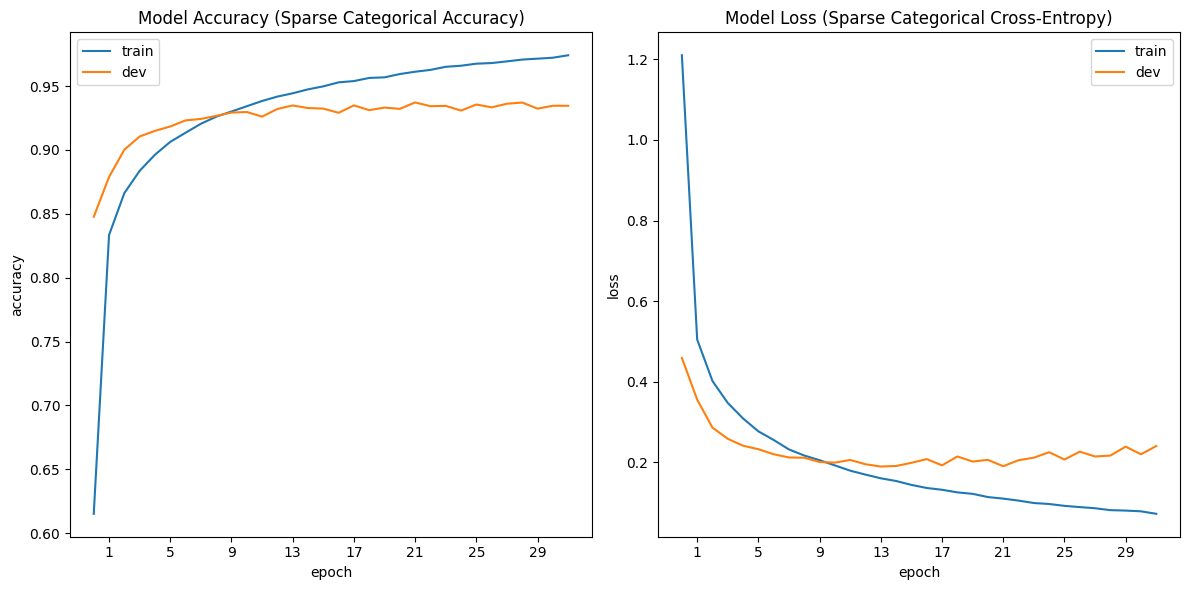

In [36]:
# Plot performance graphs
rnn_tagger.plot_curves()

### Evaluate the RNN tagger on the training set (classification report)

In [37]:
train_set = train_ds_handler.sentences
train_classification_report_df, train_macro_average_df = rnn_tagger.classification_report(train_set)

298/298 [==============================] - 266s 892ms/step


In [38]:
train_classification_report_df

,Class Id,Class Name,Precision,Recall,F1,Precision-Recall AUC
0,1,noun,0.979414,0.988349,0.983861,0.998650
1,2,punct,0.999824,0.999648,0.999736,1.000000
2,3,verb,0.990276,0.989469,0.989873,0.999326
3,4,adp,0.992309,0.992181,0.992245,0.999668
4,5,pron,0.997536,0.997536,0.997536,0.999948
5,6,det,0.998725,0.998725,0.998725,0.999983
6,7,adj,0.970384,0.975077,0.972725,0.996441
7,8,propn,0.980552,0.936117,0.957819,0.993897
8,9,aux,0.997616,0.996372,0.996994,0.999823
9,10,adv,0.972364,0.973107,0.972735,0.997151


In [39]:
train_macro_average_df

,Macro Average Precision,Macro Average Recall,Macro Average F1,Macro Average Precision Recall AUC
0,0.978839,0.983166,0.980924,0.996434


### Evaluate the RNN tagger on the dev set (classification report)

In [40]:
dev_set = dev_ds_handler.sentences
dev_classification_report_df, dev_macro_average_df = rnn_tagger.classification_report(dev_set)

42/42 [==============================] - 35s 842ms/step


In [41]:
dev_classification_report_df

,Class Id,Class Name,Precision,Recall,F1,Precision-Recall AUC
0,1,noun,0.914307,0.907426,0.910854,0.973179
1,2,punct,0.998116,0.999371,0.998743,0.999863
2,3,verb,0.946999,0.907733,0.926950,0.979092
3,4,adp,0.960036,0.971249,0.965610,0.994074
4,5,pron,0.989478,0.990347,0.989912,0.998834
5,6,det,0.993664,0.992616,0.993140,0.999767
6,7,adj,0.878396,0.857323,0.867732,0.944739
7,8,propn,0.717412,0.733463,0.725349,0.829490
8,9,aux,0.988192,0.989653,0.988922,0.999422
9,10,adv,0.906223,0.898349,0.902269,0.960811


In [42]:
dev_macro_average_df

,Macro Average Precision,Macro Average Recall,Macro Average F1,Macro Average Precision Recall AUC
0,0.856638,0.881069,0.86278,0.921327


### Evaluate the RNN tagger on the test set

In [43]:
test_set = test_ds_handler.sentences
test_classification_report_df, test_macro_average_df = rnn_tagger.classification_report(test_set)

41/41 [==============================] - 34s 835ms/step


In [44]:
test_classification_report_df

,Class Id,Class Name,Precision,Recall,F1,Precision-Recall AUC
0,1,noun,0.892647,0.896438,0.894539,0.962878
1,2,punct,0.998350,0.999339,0.998844,0.999985
2,3,verb,0.948187,0.886199,0.916145,0.973973
3,4,adp,0.962331,0.979024,0.970606,0.993801
4,5,pron,0.988578,0.991409,0.989991,0.999407
5,6,det,0.991489,0.993368,0.992428,0.999526
6,7,adj,0.853277,0.874846,0.863927,0.940753
7,8,propn,0.742036,0.730627,0.736288,0.835220
8,9,aux,0.981621,0.988225,0.984912,0.998555
9,10,adv,0.918406,0.868941,0.892989,0.956356


In [45]:
test_macro_average_df

,Macro Average Precision,Macro Average Recall,Macro Average F1,Macro Average Precision Recall AUC
0,0.859471,0.885035,0.866475,0.916391
